In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv(
    "../../data/SP500_EGS_Score_avarage_per_year.csv",
    index_col=0,
    parse_dates=True,
    sep=",",
)

In [ ]:
df.head(20)

In [ ]:
# all lower case

df.columns = map(str.lower, df.columns)

# - to _

df.columns = df.columns.str.replace("-", "_")

In [ ]:
len(df.company_symbol.unique())

In [ ]:
import sys

sys.path.append("../")

In [ ]:
from helpers.text_preprocessing.preprocess_text import preprocess_text

In [ ]:
import pandas as pd

# Load or create your DataFrame (replace 'your_data.csv' with the path to your data file)
df = pd.read_csv(
    "../data/extracted_text_sustainability_reports.csv",
    index_col=0,
    parse_dates=True,
    sep=",",
)

In [ ]:
# Preprocess the text and get the preprocessed DataFrame
preprocessed_df = preprocess_text(df)

In [ ]:
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import plotly
from gensim import corpora
import mlflow

In [ ]:
import sys

sys.path.append("../")

In [ ]:
from models.LDA_optuna_tuning.tune_lda_optuna import train_lda, compute_coherence
from models.LDA_optuna_tuning.call_optuna_tune import (
    preprocess_data,
    execute_optuna_study,
)

In [ ]:
df = pd.read_csv(
    "../data/preprocessed_data_text_format.csv", index_col=0, parse_dates=True, sep=","
)

In [ ]:
df = df.head(200)

In [ ]:
# write the preprocessed data to csv
df.to_csv("../data/preprocessed_data_text_format_200.csv")

In [ ]:
preprocessed_stats = {
    "Number of Missing Values": df["preprocessed_content"].isna().sum(),
    "Number of Unique Texts": df["preprocessed_content"].nunique(),
    "Sample Texts": df["preprocessed_content"].sample(5).tolist(),
}

preprocessed_stats

In [ ]:
df

In [ ]:
if mlflow.active_run():
    mlflow.end_run()
execute_optuna_study(df, n_trials=200)

In [ ]:
import yfinance as yf

In [ ]:
# Create a ticker object
tesla = yf.Ticker("TSLA")

# To fetch row names from financials and put them in a list
financials_rows = tesla.financials.index.tolist()
print("Financials Rows:", financials_rows)

# To fetch row names from cashflow and put them in a list
cashflow_rows = tesla.cashflow.index.tolist()
print("Cashflow Rows:", cashflow_rows)

# To fetch row names from balance sheet and put them in a list
balance_rows = tesla.balance_sheet.index.tolist()
print("Balance Rows:", balance_rows)

print(tesla.info)

In [ ]:
import pandas as pd
from collections import Counter

df = pd.read_csv(
    "../data/ready_to_model/ready_to_model_df.csv",
    index_col=0,
    parse_dates=True,
    sep=",",
)

In [ ]:
# Filter out any non-string values in the 'preprocessed_content' column
df["preprocessed_content"] = df["preprocessed_content"].apply(
    lambda x: x if isinstance(x, str) else ""
)

# Tokenize the 'preprocessed_content' and flatten the list
all_words = [word for content in df["preprocessed_content"] for word in content.split()]

# Count the frequency of each word
counter = Counter(all_words)

# Display the 10 most common and 10 least common words
most_common_words = counter.most_common(300)
least_common_words = [word for word, count in counter.items() if count <= 2]


print("Most common words", most_common_words)
print("Least common words", least_common_words)
print(len(most_common_words))
print(len(least_common_words))

In [1]:
from sklearn.model_selection import train_test_split, KFold

import tpot2
import sklearn
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("../data/model_data/model_data.csv")
df_sample = df.sample(100, random_state=100)

In [3]:
df.head()

,unnamed: 0,filename,ticker,year,preprocessed_content,ner_entities,topic_0,topic_1,topic_2,topic_3,...,svd_dim_195,svd_dim_196,svd_dim_197,svd_dim_198,svd_dim_199,company_symbol,total_score,e_score,s_score,g_score
0,6,NYSE_LH_2021.pdf,LH,2021,create healthy tomorrow rat table_content envi...,"['s p o n s i b il', 'o m p', 'sandra van der ...",0.001218,0.001870,0.002429,0.185920,...,-0.127166,-0.009091,0.078761,0.125909,0.055451,LH,15.30,0.67,7.67,6.96
1,7,NYSE_MTB_2020.pdf,MTB,2020,environmental_social difference welcome enviro...,"['first', 'bn% $', 'the past three years', 'ye...",0.000938,0.002150,0.001672,0.037319,...,-0.019051,0.018282,0.043107,-0.145434,-0.027739,MTB,27.66,2.12,12.80,12.74
2,8,NASDAQ_EXPD_2021.pdf,EXPD,2021,expediter sustainability report report work pr...,"['each year', 'this year', 'community involvem...",0.001615,0.003504,0.003851,0.122123,...,-0.069302,-0.043380,-0.128714,-0.079893,0.071137,EXPD,18.13,4.05,9.23,4.84
3,10,NASDAQ_WDC_2019.pdf,WDC,2019,date step sustainability report table_content ...,"['year', 'the coming years', 'david goeckeler'...",0.000771,0.000802,0.000955,0.001158,...,-0.111684,-0.029676,0.012726,-0.107914,0.028020,WDC,18.25,3.01,7.75,7.39
4,11,NASDAQ_FTNT_2021.pdf,FTNT,2021,report vision drive networking world fortune a...,"['american multinational corporation', 'sunnyv...",0.001340,0.001617,0.001802,0.637962,...,0.099068,0.088316,-0.105455,0.131043,-0.076310,FTNT,21.07,1.33,13.57,6.17


In [4]:
# columns to drop
columns_to_drop = [
    "e_score",
    "s_score",
    "g_score",
    "unnamed: 0",
    "filename",
    "ticker",
    "year",
    "preprocessed_content",
    "ner_entities",
    "company_symbol",
    "total_score",
]

# Separate features and target
y = df["total_score"]
X = df.drop(columns=columns_to_drop)

In [5]:
# drop the last two rows
X = X.iloc[:-2, :]

In [6]:
y = y.iloc[:-2]

In [7]:
X

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,svd_dim_190,svd_dim_191,svd_dim_192,svd_dim_193,svd_dim_194,svd_dim_195,svd_dim_196,svd_dim_197,svd_dim_198,svd_dim_199
0,0.001218,0.001870,0.002429,0.185920,0.003068,0.002446,0.002079,0.004457,0.002653,0.001272,...,-0.024080,-0.148518,0.164279,-0.048198,0.083931,-0.127166,-0.009091,0.078761,0.125909,0.055451
1,0.000938,0.002150,0.001672,0.037319,0.000956,0.001582,0.000889,0.001315,0.001176,0.001106,...,-0.030027,0.098111,-0.003598,0.109171,0.141098,-0.019051,0.018282,0.043107,-0.145434,-0.027739
2,0.001615,0.003504,0.003851,0.122123,0.012733,0.710308,0.002722,0.005965,0.081098,0.001468,...,-0.034874,0.084783,0.175532,0.028276,0.154551,-0.069302,-0.043380,-0.128714,-0.079893,0.071137
3,0.000771,0.000802,0.000955,0.001158,0.000978,0.632143,0.000848,0.000936,0.000806,0.000852,...,-0.169075,0.036839,-0.230197,-0.095408,0.120083,-0.111684,-0.029676,0.012726,-0.107914,0.028020
4,0.001340,0.001617,0.001802,0.637962,0.001676,0.243458,0.001693,0.003728,0.001563,0.001501,...,0.072187,-0.181659,0.062215,-0.163555,0.278604,0.099068,0.088316,-0.105455,0.131043,-0.076310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840,0.000242,0.000364,0.000372,0.000452,0.000292,0.000323,0.000341,0.000364,0.000253,0.000222,...,-0.032139,0.137511,0.110929,-0.028941,0.191487,0.065250,0.043178,-0.100021,-0.105388,0.005013
841,0.001257,0.001116,0.001339,0.002035,0.000916,0.001633,0.001734,0.001064,0.156478,0.000856,...,0.074158,-0.009078,-0.022865,0.034781,0.011008,-0.106153,-0.186899,0.002192,0.005044,0.073231
842,0.003077,0.339887,0.003480,0.050167,0.003389,0.015454,0.006424,0.004994,0.003117,0.003943,...,0.108275,-0.037982,0.020480,0.012006,-0.020250,-0.024281,0.096345,-0.115631,0.146167,-0.024513
843,0.001088,0.775492,0.001835,0.053042,0.001516,0.002567,0.001855,0.001733,0.001633,0.001249,...,0.161362,-0.159340,0.063446,-0.006558,-0.284456,0.032855,-0.135835,0.032785,0.049013,0.026218


In [8]:
y

0      15.30
1      27.66
2      18.13
3      18.25
4      21.07
       ...  
840    28.98
841    18.73
842    21.70
843    30.41
844    19.73
Name: total_score, Length: 845, dtype: float64

In [9]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=100
)

/Users/nikitawilms/Documents/ffm-ds-23-2/ESG-Score-Prediction-from-Sustainability-Reports/.venv/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 64697 instead
  warnings.warn(
Evaluations: : 108it [10:00,  5.56s/it]
/Users/nikitawilms/Documents/ffm-ds-23-2/ESG-Score-Prediction-from-Sustainability-Reports/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:114: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_w

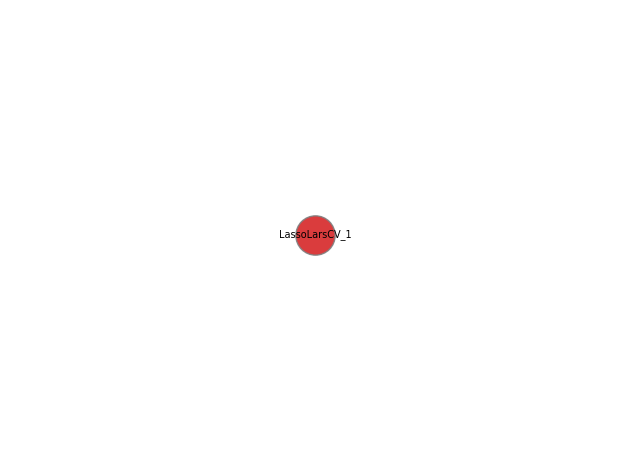

    mean_squared_error Parents Variation_Function  \
0              TIMEOUT     NaN                NaN   
1           -36.995326     NaN                NaN   
2              INVALID     NaN                NaN   
3           -37.061055     NaN                NaN   
4           -51.030991     NaN                NaN   
..                 ...     ...                ...   
109         -45.413985   (53,)             mutate   
110         -45.168354   (32,)             mutate   
111         -56.855117  (109,)             mutate   
112                NaN   (34,)             mutate   
113         -45.664361    (1,)             mutate   

                          Individual  Submitted Timestamp  \
0                 ['ElasticNetCV_1']         1.695891e+09   
1          ['ExtraTreesRegressor_1']         1.695891e+09   
2    ['GradientBoostingRegressor_1']         1.695891e+09   
3            ['AdaBoostRegressor_1']         1.695891e+09   
4        ['DecisionTreeRegressor_1']         1.695891e+09 

'# Evaluate on test data\ntest_score = est.score(X_test, y_test)\n\n# Print test score\nprint(f"Test Score (Negative MSE): {test_score}")\n\n# Get the best pipeline\nprint(f"Optimized Pipeline: {est.fitted_pipeline_}")\n\n# Get top models in the Pareto front\npareto_front = est.evaluated_individuals[est.evaluated_individuals["Pareto_Front"] == 1]\nprint(f"Top models in the Pareto front: {pareto_front}")'

In [11]:
scorer = sklearn.metrics.get_scorer("neg_mean_squared_error")

# Initialize TPOT2 regressor with K-Fold cross-validation
est = tpot2.TPOTEstimatorSteadyState(
    n_jobs=7,
    cv=KFold(n_splits=5),  # 5-Fold cross-validation
    verbose=2,
    classification=False,
    scorers=[scorer],
    scorers_weights=[1],
    max_eval_time_seconds=60 * 15,
    max_time_seconds=60 * 90,
)

# Fit the model
est.fit(X_train, y_train)

df_individuals = est.evaluated_individuals

# Convert the 'mean_squared_error' column to numeric, errors='coerce' will replace non-numeric with NaN
df_individuals['mean_squared_error'] = pd.to_numeric(df_individuals['mean_squared_error'], errors='coerce')

# Drop NaN values
filtered_df = df_individuals.dropna(subset=['mean_squared_error'])

# Sort the DataFrame by 'mean_squared_error' and get the top 10
top_10_mse = filtered_df.nlargest(10, 'mean_squared_error')

print(top_10_mse)

# Optionally, you can save the pipeline to a file
# with open("optimized_pipeline_regression.py", "w") as f:
#     f.write(est.export())

In [13]:
df_new = est.evaluated_individuals

In [18]:
# Convert the 'mean_squared_error' column to numeric, errors='coerce' will replace non-numeric with NaN
df_new['mean_squared_error'] = pd.to_numeric(df_new['mean_squared_error'], errors='coerce')

# Drop NaN values
filtered_df = df_new.dropna(subset=['mean_squared_error'])

# Sort the DataFrame by 'mean_squared_error' and get the top 10
top_10_mse = filtered_df.nlargest(10, 'mean_squared_error')

In [19]:
top_10_mse

,mean_squared_error,Parents,Variation_Function,Individual,Submitted Timestamp,Completed Timestamp,Pareto_Front,Instance
6,-28.367576,NaN,NaN,['LassoLarsCV_1'],1.695891e+09,1.695891e+09,1.0,['LassoLarsCV_1']
82,-31.892540,"(7,)",mutate,['AdaBoostRegressor_1'],1.695891e+09,1.695891e+09,NaN,['AdaBoostRegressor_1']
34,-32.157618,NaN,NaN,['XGBRegressor_1'],1.695891e+09,1.695891e+09,NaN,['XGBRegressor_1']
94,-32.494554,"(38,)",mutate,['RandomForestRegressor_1'],1.695891e+09,1.695891e+09,NaN,['RandomForestRegressor_1']
39,-33.427426,NaN,NaN,['AdaBoostRegressor_1'],1.695891e+09,1.695891e+09,NaN,['AdaBoostRegressor_1']
57,-33.856640,"(1,)",mutate,['ExtraTreesRegressor_1'],1.695891e+09,1.695891e+09,NaN,['ExtraTreesRegressor_1']
58,-33.856956,"(57,)",mutate,"[('ExtraTreesRegressor_1', 'Normalizer_1')]",1.695891e+09,1.695891e+09,NaN,"[('ExtraTreesRegressor_1', 'Normalizer_1')]"
78,-34.672086,"(8,)",mutate,['RandomForestRegressor_1'],1.695891e+09,1.695891e+09,NaN,['RandomForestRegressor_1']
8,-34.757328,NaN,NaN,['RandomForestRegressor_1'],1.695891e+09,1.695891e+09,NaN,['RandomForestRegressor_1']
27,-34.785620,NaN,NaN,['AdaBoostRegressor_1'],1.695891e+09,1.695891e+09,NaN,['AdaBoostRegressor_1']
